In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

# Data Preprocessing

### Load Dataset

In [40]:
df = pd.read_csv('./data/AAPL.csv') 

In [41]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [42]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
9818,2019-11-19,267.899994,268.000000,265.390015,266.290009,266.290009,19041800.0
9819,2019-11-20,265.540009,266.079987,260.399994,263.190002,263.190002,26558600.0
9820,2019-11-21,263.690002,264.010010,261.179993,262.010010,262.010010,30348800.0
9821,2019-11-22,262.589996,263.179993,260.839996,261.779999,261.779999,16331300.0
9822,2019-11-25,262.709991,266.440002,262.519989,266.369995,266.369995,21005100.0


In [43]:
df.shape

(9823, 7)

In [44]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [45]:
df.isna().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [46]:
df.isna().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [47]:
df[df.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
165,1981-08-10,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df = df.dropna()

In [49]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [50]:
df.duplicated().sum()

np.int64(0)

### Feature Selection

In [51]:
# Convert the Date column to a datetime format and set it as the index.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [52]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [53]:
df.shape

(9822, 6)

In [56]:
data = df[['Adj Close']].values

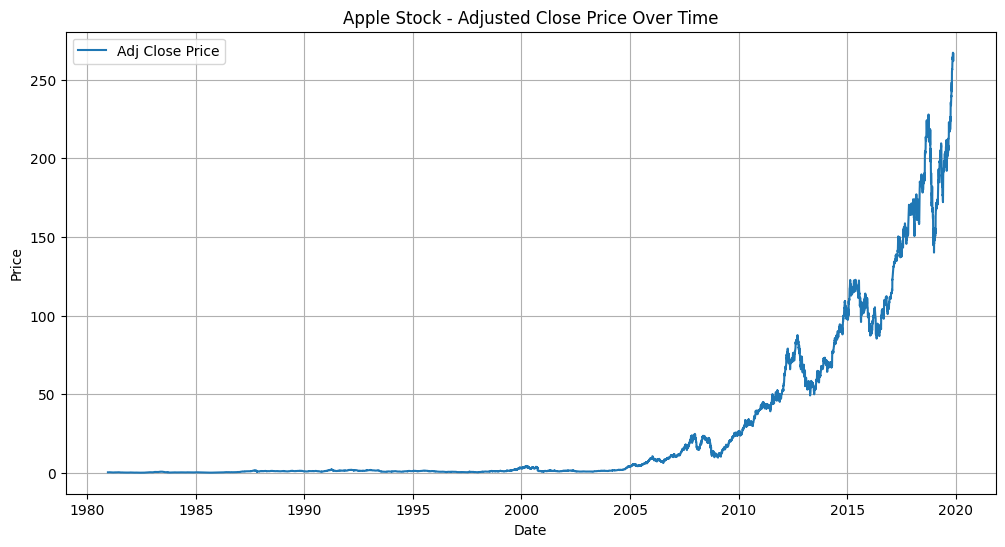

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close'], label='Adj Close Price')
plt.title('Apple Stock - Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Normalize data

In [65]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[9.43040495e-04],
       [8.63345877e-04],
       [7.57087635e-04],
       ...,
       [9.80932345e-01],
       [9.80070700e-01],
       [9.97265303e-01]])

### Create Sequences

In [66]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Reshape for RNN: (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X

array([[[9.43040495e-04],
        [8.63345877e-04],
        [7.57087635e-04],
        ...,
        [7.77013162e-04],
        [6.70754920e-04],
        [6.10982083e-04]],

       [[8.63345877e-04],
        [7.57087635e-04],
        [7.90293101e-04],
        ...,
        [6.70754920e-04],
        [6.10982083e-04],
        [5.64496678e-04]],

       [[7.57087635e-04],
        [7.90293101e-04],
        [8.30140410e-04],
        ...,
        [6.10982083e-04],
        [5.64496678e-04],
        [6.10982083e-04]],

       ...,

       [[7.67047727e-01],
        [7.80045113e-01],
        [7.79036736e-01],
        ...,
        [1.00000000e+00],
        [9.96965667e-01],
        [9.85352718e-01]],

       [[7.80045113e-01],
        [7.79036736e-01],
        [7.67682613e-01],
        ...,
        [9.96965667e-01],
        [9.85352718e-01],
        [9.80932345e-01]],

       [[7.79036736e-01],
        [7.67682613e-01],
        [7.80717441e-01],
        ...,
        [9.85352718e-01],
        [9.8093

### Split Dataset into Train & Test

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Model Development

Define SimpleRNN & LSTM Architecture: 
1. Use Sequential from tensorflow.keras to build a SimpleRNN/LSTM model.

Layers used:
1. SimpleRNN/LSTM layer for learning sequential dependencies.
2. Dropout layer to prevent overfitting.
3. Dense layer to output the predicted stock price.

### SimpleRNN

In [68]:
rnn_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    SimpleRNN(units=50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training - Use Early Stopping and ModelCheckpoint

In [69]:
early_stop = EarlyStopping(
    monitor='val_loss',       
    patience=5,               
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',         
    monitor='val_loss',
    save_best_only=True,      
    mode='min',
    verbose=1
)

# Fit the model with validation split and callbacks
history = rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/50
217/220 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9892e-05 
Epoch 1: val_loss improved from inf to 0.00001, saving model to best_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.9499e-05 - val_loss: 1.2681e-05
Epoch 2/50
217/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7173e-06
Epoch 2: val_loss did not improve from 0.00001
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.7091e-06 - val_loss: 1.6093e-05
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9843e-06 
Epoch 3: val_loss did not improve from 0.00001
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.9809e-06 - val_loss: 2.6632e-05
Epoch 4/50
218/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1807e-06
Epoch 4: val_loss improved from 0.00001 to 0.00001, saving model to best_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.1732e-06 - val_loss: 9.0464e-06
Epoch 5/50
215/220 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2961e-06 
Epoch 5: val_loss did not improve from 0.00001
22

### LSTM

In [70]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1],1)),
    LSTM(units=50, activation='tanh'),
    Dropout(0.2),
    Dense(units=1)
])

LSTM_model.compile(optimizer='adam', loss='mean_squared_error')
LSTM_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_lstm_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the LSTM model
history = LSTM_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.9685e-05
Epoch 1: val_loss improved from inf to 0.00002, saving model to best_lstm_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 5.9506e-05 - val_loss: 2.0342e-05
Epoch 2/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.2718e-06
Epoch 2: val_loss did not improve from 0.00002
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 4.2723e-06 - val_loss: 7.7396e-05
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4007e-06
Epoch 3: val_loss did not improve from 0.00002
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 4.4016e-06 - val_loss: 2.5277e-05
Epoch 4/20
218/220 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2261e-06
Epoch 4: val_loss improved from 0.00002 to 0.00002, saving model to best_lstm_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 3.2289e-06 - val_loss: 1.5597e-05
Epoch 5/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6854e-06
Epoch 5: val_loss did not improve 

# Model Evaluation & Prediction

### SimpleRNN Model to predict stock prices on the test set

In [72]:
rnn_model = load_model('best_model.keras', compile=False)

In [73]:
predicted_scaled = rnn_model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_scaled)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


In [74]:
mse = mean_squared_error(actual_prices, predicted_prices)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 8.9462


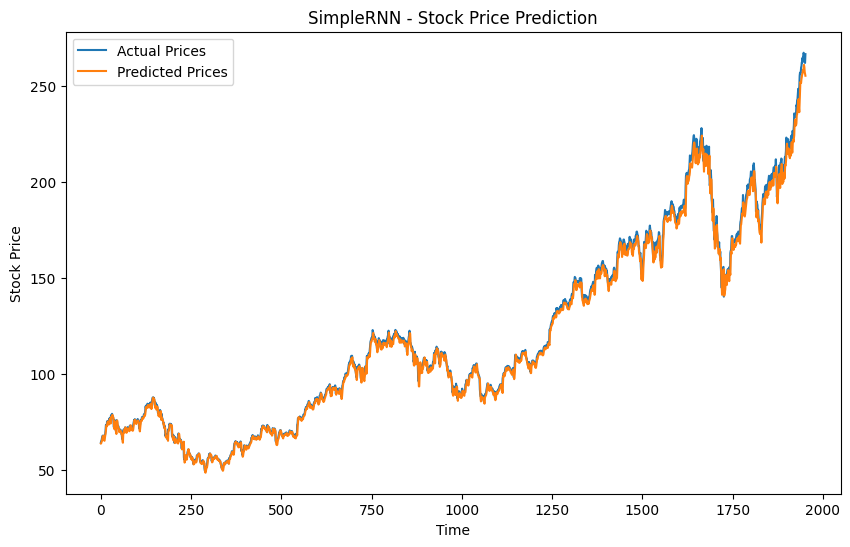

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('SimpleRNN - Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### LSTM to predict stock prices on test

In [76]:
lstm_model = load_model('best_lstm_model.keras', compile=False)
lstm_predicted_scaled = lstm_model.predict(X_test)
lstm_predicted_prices = scaler.inverse_transform(lstm_predicted_scaled)
lstm_actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 


In [77]:
mse = mean_squared_error(lstm_actual_prices, lstm_predicted_prices)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 8.7669


In [112]:
X_test.shape

(1953, 60, 1)

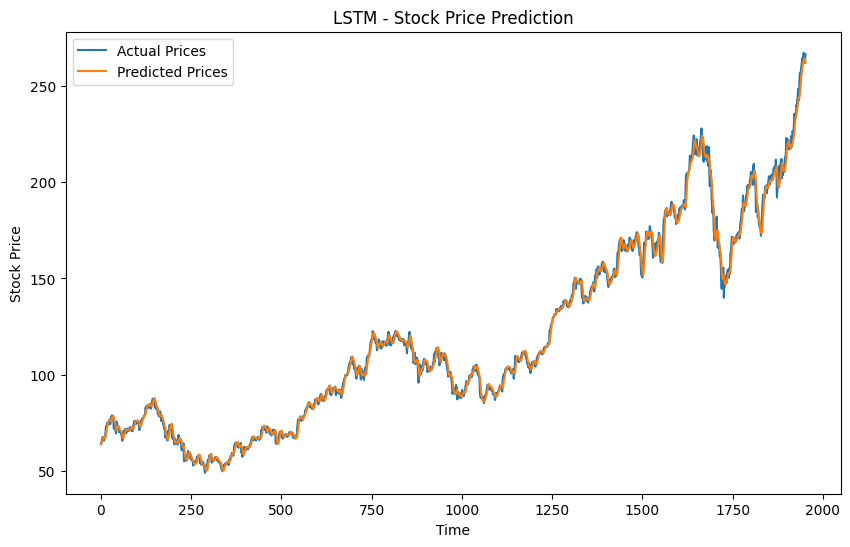

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_actual_prices, label='Actual Prices')
plt.plot(lstm_predicted_prices, label='Predicted Prices')
plt.title('LSTM - Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### 5 days Stock Price Prediction using the trained LSTM Model and using last 60 days in the sequence

In [120]:
last_60_days = scaled_data[-60:]
last_60_days.shape

(60, 1)

In [79]:
def predict_n_days(model, last_sequence, n_days, scaler):
    predictions = []
    input_seq = last_sequence.copy()  # shape: (60, 1)

    for _ in range(n_days):
        input_reshaped = input_seq.reshape(1, input_seq.shape[0], 1)
        pred = model.predict(input_reshaped, verbose=0)[0][0]  # predict next day
        predictions.append(pred)

        # Append predicted value and remove first one to keep window size constant
        input_seq = np.append(input_seq[1:], [[pred]], axis=0)

    # Inverse transform predictions
    predictions = np.array(predictions).reshape(-1, 1)
    return scaler.inverse_transform(predictions)

In [121]:
predicted_5_days = predict_n_days(lstm_model, last_60_days , 5 , scaler)

In [122]:
print(predicted_5_days)

[[262.35883]
 [261.72675]
 [261.0022 ]
 [260.2044 ]
 [259.3522 ]]


In [107]:
actual_5_days = df['Adj Close'].values[-5:]
actual_5_days = actual_5_days.reshape(-1, 1)
actual_5_days.shape

(5, 1)

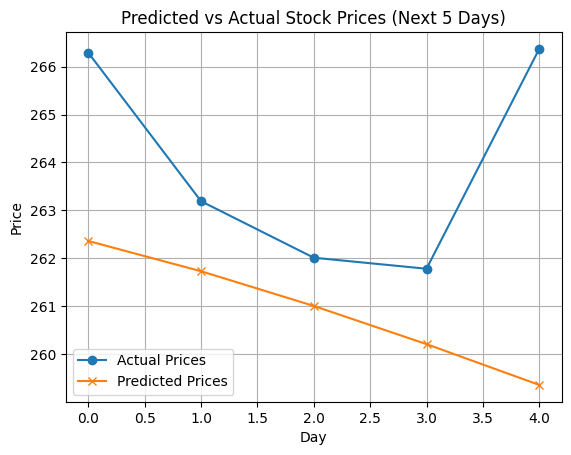

In [108]:
plt.plot(actual_5_days, label='Actual Prices', marker='o')
plt.plot(predicted_5_days, label='Predicted Prices', marker='x')
plt.title('Predicted vs Actual Stock Prices (Next 5 Days)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### 15 days Stock Price Prediction using the trained LSTM Model and using last 60 days in the sequence

In [93]:
predicted_15_days = predict_n_days(lstm_model, last_60_days , 15 , scaler)

In [94]:
print(predicted_15_days)

[[262.35883]
 [261.72675]
 [261.0022 ]
 [260.2044 ]
 [259.3522 ]
 [258.46008]
 [257.53937]
 [256.59885]
 [255.64561]
 [254.68507]
 [253.72148]
 [252.7582 ]
 [251.79796]
 [250.84264]
 [249.89404]]


In [96]:
actual_15_days = df['Adj Close'].values[-15:]
actual_15_days = actual_15_days.reshape(-1, 1)
actual_15_days.shape

(15, 1)

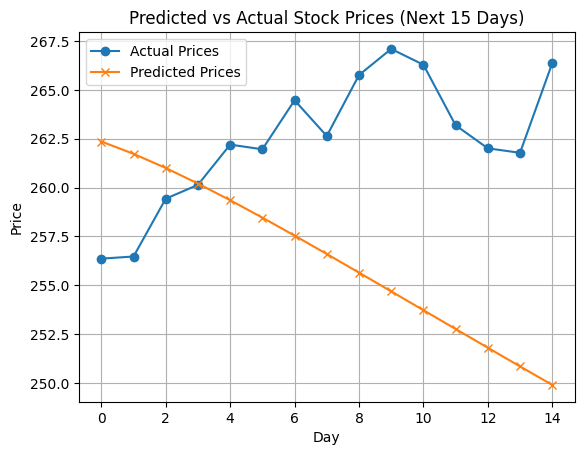

In [97]:
plt.plot(actual_15_days, label='Actual Prices', marker='o')
plt.plot(predicted_15_days, label='Predicted Prices', marker='x')
plt.title('Predicted vs Actual Stock Prices (Next 15 Days)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
def create_sequences_multi_day(data, seq_length, prediction_days=5):
    """
    Create sequences for predicting multiple days ahead.
    
    Parameters:
    -----------
    data : numpy array
        Input time series data with shape (n_samples, n_features)
    seq_length : int
        Number of time steps to use for each input sequence
    prediction_days : int
        Number of days to predict ahead (default: 5)
        
    Returns:
    --------
    X : numpy array
        Input sequences with shape (n_samples, seq_length, n_features)
    y : numpy array
        Target values with shape (n_samples, prediction_days)
    """
    X, y = [], []
    
    # Make sure we have enough data for the prediction window
    for i in range(seq_length, len(data) - prediction_days + 1):
        # Input sequence
        X.append(data[i-seq_length:i, 0])
        
        # Target: next 'prediction_days' values
        y.append(data[i:i+prediction_days, 0])
    
    return np.array(X), np.array(y)

sequence_length = 60
prediction_days = 5

X_multi, y_multi = create_sequences_multi_day(scaled_data, sequence_length, prediction_days)

# Reshape for RNN: (samples, time steps, features)
X_multi = np.reshape(X_multi, (X_multi.shape[0], X_multi.shape[1], 1))

print(f"X shape: {X_multi.shape}")  # Should be (n_samples, sequence_length, 1)
print(f"y shape: {y_multi.shape}")  # Should be (n_samples, prediction_days)


X shape: (9758, 60, 1)
y shape: (9758, 5)


In [116]:
lstm5_predicted_scaled = lstm_model.predict(X_multi)
lstm5_predicted_prices = scaler.inverse_transform(lstm5_predicted_scaled)
lstm5_actual_prices = scaler.inverse_transform(y_multi.reshape(-1, 1))

305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step 


In [118]:
lstm5_actual_prices

array([[  0.306697],
       [  0.319106],
       [  0.315561],
       ...,
       [262.01001 ],
       [261.779999],
       [266.369995]])

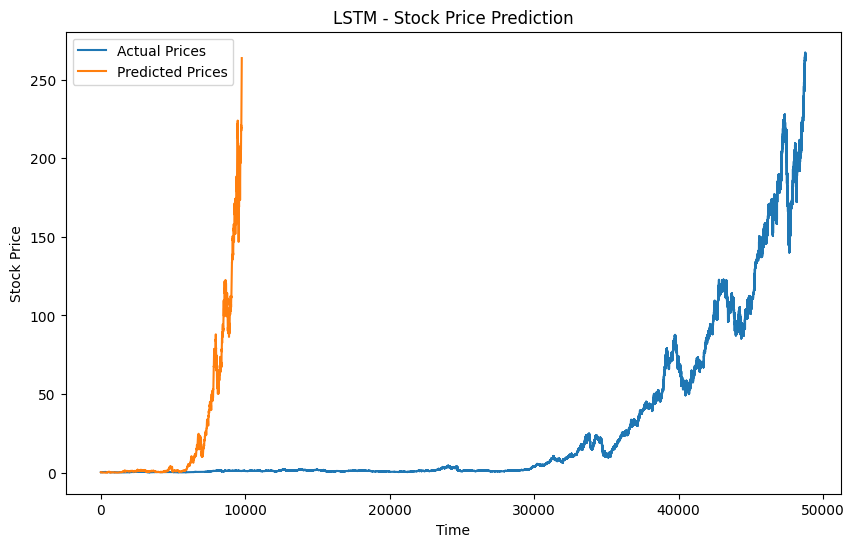

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(lstm5_actual_prices, label='Actual Prices')
plt.plot(lstm5_predicted_prices, label='Predicted Prices')
plt.title('LSTM - Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()